In [58]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import lazypredict
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from datetime import datetime, timedelta
import re

import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
# nltk.download('stopwords')
from nltk.corpus import stopwords
# nltk.download('wordnet')
from nltk.corpus import wordnet
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

stopwords = set(stopwords.words('english'))
new_stopwords = ['ba', 'british', 'airways','fly','airway', 'flight',]
stopwords = stopwords.union(new_stopwords)


In [59]:
# data = pd.read_csv('data/BA_reviews - 100 reviews - cleaned.csv')
# data = pd.read_csv('data/BA_reviews - 1000 reviews - cleaned.csv')
data = pd.read_csv('data/BA_reviews - 3000 reviews - cleaned.csv')

data

,Unnamed: 0,dummy,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,...,full reviews,review date,verified,reviews,rec,date difference,month,year,traveller,seat
0,0,0,Boeing 777,NaN,Economy Class,Los Angeles to London,2023-08-15,1.0,1.0,1.0,...,✅ Trip Verified | British Airways absolutely ...,2023-09-01,1,British Airways absolutely does not care. My...,0,17,8,2023,NaN,0
1,1,0,NaN,Couple Leisure,Economy Class,New York JFK to Malaga via London,2023-06-15,1.0,3.0,NaN,...,✅ Trip Verified | My recent experience with B...,2023-09-01,1,My recent experience with British Airways wa...,0,78,6,2023,2.0,0
2,2,0,NaN,Couple Leisure,Premium Economy,Chicago to Rome via London,2023-07-15,3.0,1.0,1.0,...,✅ Trip Verified | This is to express our disp...,2023-08-31,1,This is to express our displeasure and conce...,0,47,7,2023,2.0,1
3,3,0,A320,Solo Leisure,Business Class,London to Malaga,2023-08-15,1.0,1.0,1.0,...,✅ Trip Verified | I flew London to Malaga on ...,2023-08-30,1,I flew London to Malaga on 27 August in Club...,0,15,8,2023,1.0,2
4,4,0,NaN,Solo Leisure,Economy Class,Frankfurt to London Heathrow,2023-08-15,1.0,1.0,NaN,...,✅ Trip Verified | I arrived at the airport ab...,2023-08-30,1,I arrived at the airport about 2.5 hours bef...,0,15,8,2023,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0,NaN,Solo Leisure,Economy Class,LHR to BUD,2016-10-15,1.0,1.0,1.0,...,✅ Verified Review | London Heathrow to Budapes...,2016-10-12,1,London Heathrow to Budapest with British Airw...,0,-3,10,2016,1.0,0
1996,1996,0,A380,Couple Leisure,First Class,IAD to NBO via LHR,2016-09-15,2.0,4.0,4.0,...,✅ Verified Review | Washington Dulles to Nair...,2016-10-11,1,Washington Dulles to Nairobi via London. Was...,0,26,9,2016,2.0,First Class
1997,1997,0,A320,Family Leisure,Economy Class,AGP to LGW,2016-10-15,2.0,4.0,1.0,...,✅ Verified Review | Flew Malaga to Gatwick. A...,2016-10-11,1,Flew Malaga to Gatwick. Although a better fl...,0,-4,10,2016,3.0,0
1998,1998,0,Boeing 777,Couple Leisure,Business Class,LGW to MRU,2016-10-15,3.0,4.0,2.0,...,| We were very excited about our Club World jo...,2016-10-10,0,We were very excited about our Club World jou...,0,-5,10,2016,2.0,2


In [60]:
reviews = data['reviews']
reviews

0         British Airways absolutely does not care. My...
1         My recent experience with British Airways wa...
2         This is to express our displeasure and conce...
3         I flew London to Malaga on 27 August in Club...
4         I arrived at the airport about 2.5 hours bef...
                              ...                        
1995     London Heathrow to Budapest with British Airw...
1996      Washington Dulles to Nairobi via London. Was...
1997      Flew Malaga to Gatwick. Although a better fl...
1998     We were very excited about our Club World jou...
1999     Return journey Gatwick to Dubrovnik. Outward ...
Name: reviews, Length: 2000, dtype: object

In [61]:
def clean_text(text):
    text = re.sub('[^A-Za-z]+', ' ', str(text)) #remove number and special characters
    lower_case_text = text.lower() #convert to lower case
    return lower_case_text


pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def pos_tagging(clean_text):
    tagged_words = pos_tag(word_tokenize(clean_text.lower())) #tokenize and tag the words
    tagged_list = []
    for word, tag in tagged_words:
        if word not in stopwords:
          tagged_list.append(tuple([word, pos_dict.get(tag[0])]))    
    return tagged_list


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


In [62]:
data['cleaned reviews'] = data['reviews'].apply(clean_text)
data['pos tagged reviews'] = data['cleaned reviews'].apply(pos_tagging)
data['lemmatized reviews'] = data['pos tagged reviews'].apply(lemmatize)

data

,Unnamed: 0,dummy,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,...,reviews,rec,date difference,month,year,traveller,seat,cleaned reviews,pos tagged reviews,lemmatized reviews
0,0,0,Boeing 777,NaN,Economy Class,Los Angeles to London,2023-08-15,1.0,1.0,1.0,...,British Airways absolutely does not care. My...,0,17,8,2023,NaN,0,british airways absolutely does not care my r...,"[(absolutely, r), (care, v), (reserved, a), (s...",absolutely care reserved seat change aisle c...
1,1,0,NaN,Couple Leisure,Economy Class,New York JFK to Malaga via London,2023-06-15,1.0,3.0,NaN,...,My recent experience with British Airways wa...,0,78,6,2023,2.0,0,my recent experience with british airways was...,"[(recent, a), (experience, n), (horrendous, a)...",recent experience horrendous utter abdicatio...
2,2,0,NaN,Couple Leisure,Premium Economy,Chicago to Rome via London,2023-07-15,3.0,1.0,1.0,...,This is to express our displeasure and conce...,0,47,7,2023,2.0,1,this is to express our displeasure and concer...,"[(express, v), (displeasure, n), (concerns, n)...",express displeasure concern regard italy tri...
3,3,0,A320,Solo Leisure,Business Class,London to Malaga,2023-08-15,1.0,1.0,1.0,...,I flew London to Malaga on 27 August in Club...,0,15,8,2023,1.0,2,i flew london to malaga on august in club eur...,"[(flew, v), (london, n), (malaga, v), (august,...",fly london malaga august club europe stand a...
4,4,0,NaN,Solo Leisure,Economy Class,Frankfurt to London Heathrow,2023-08-15,1.0,1.0,NaN,...,I arrived at the airport about 2.5 hours bef...,0,15,8,2023,1.0,0,i arrived at the airport about hours before t...,"[(arrived, v), (airport, n), (hours, n), (take...",arrive airport hour takeoff time get check g...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0,NaN,Solo Leisure,Economy Class,LHR to BUD,2016-10-15,1.0,1.0,1.0,...,London Heathrow to Budapest with British Airw...,0,-3,10,2016,1.0,0,london heathrow to budapest with british airw...,"[(london, n), (heathrow, n), (budapest, v), (y...",london heathrow budapest yet another abysmal...
1996,1996,0,A380,Couple Leisure,First Class,IAD to NBO via LHR,2016-09-15,2.0,4.0,4.0,...,Washington Dulles to Nairobi via London. Was...,0,26,9,2016,2.0,First Class,washington dulles to nairobi via london was e...,"[(washington, n), (dulles, v), (nairobi, v), (...",washington dull nairobi via london excite fi...
1997,1997,0,A320,Family Leisure,Economy Class,AGP to LGW,2016-10-15,2.0,4.0,1.0,...,Flew Malaga to Gatwick. Although a better fl...,0,-4,10,2016,3.0,0,flew malaga to gatwick although a better flig...,"[(flew, a), (malaga, n), (gatwick, v), (althou...",flew malaga gatwick although good two week a...
1998,1998,0,Boeing 777,Couple Leisure,Business Class,LGW to MRU,2016-10-15,3.0,4.0,2.0,...,We were very excited about our Club World jou...,0,-5,10,2016,2.0,2,we were very excited about our club world jou...,"[(excited, v), (club, n), (world, n), (journey...",excite club world journey mauritius disappoi...


In [63]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()


def sentiment_score(text):
    sentiment_score = sentiment_analyzer.polarity_scores(text)
    return sentiment_score['compound']

def sentiment_analysis(sentiment_score):
    analysis=[]
    if sentiment_score >= 0.4:
        return 'Positive'
    elif sentiment_score < -0.4:
        return 'Negative'
    else:
        return 'Neutral'   
    return analysis

In [64]:
data['sentiment score'] = data['lemmatized reviews'].apply(sentiment_score)
data['sentiment analysis'] = data['sentiment score'].apply(sentiment_analysis)
data

,Unnamed: 0,dummy,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,...,date difference,month,year,traveller,seat,cleaned reviews,pos tagged reviews,lemmatized reviews,sentiment score,sentiment analysis
0,0,0,Boeing 777,NaN,Economy Class,Los Angeles to London,2023-08-15,1.0,1.0,1.0,...,17,8,2023,NaN,0,british airways absolutely does not care my r...,"[(absolutely, r), (care, v), (reserved, a), (s...",absolutely care reserved seat change aisle c...,-0.9022,Negative
1,1,0,NaN,Couple Leisure,Economy Class,New York JFK to Malaga via London,2023-06-15,1.0,3.0,NaN,...,78,6,2023,2.0,0,my recent experience with british airways was...,"[(recent, a), (experience, n), (horrendous, a)...",recent experience horrendous utter abdicatio...,-0.9272,Negative
2,2,0,NaN,Couple Leisure,Premium Economy,Chicago to Rome via London,2023-07-15,3.0,1.0,1.0,...,47,7,2023,2.0,1,this is to express our displeasure and concer...,"[(express, v), (displeasure, n), (concerns, n)...",express displeasure concern regard italy tri...,-0.4588,Negative
3,3,0,A320,Solo Leisure,Business Class,London to Malaga,2023-08-15,1.0,1.0,1.0,...,15,8,2023,1.0,2,i flew london to malaga on august in club eur...,"[(flew, v), (london, n), (malaga, v), (august,...",fly london malaga august club europe stand a...,-0.7430,Negative
4,4,0,NaN,Solo Leisure,Economy Class,Frankfurt to London Heathrow,2023-08-15,1.0,1.0,NaN,...,15,8,2023,1.0,0,i arrived at the airport about hours before t...,"[(arrived, v), (airport, n), (hours, n), (take...",arrive airport hour takeoff time get check g...,-0.0258,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0,NaN,Solo Leisure,Economy Class,LHR to BUD,2016-10-15,1.0,1.0,1.0,...,-3,10,2016,1.0,0,london heathrow to budapest with british airw...,"[(london, n), (heathrow, n), (budapest, v), (y...",london heathrow budapest yet another abysmal...,-0.8860,Negative
1996,1996,0,A380,Couple Leisure,First Class,IAD to NBO via LHR,2016-09-15,2.0,4.0,4.0,...,26,9,2016,2.0,First Class,washington dulles to nairobi via london was e...,"[(washington, n), (dulles, v), (nairobi, v), (...",washington dull nairobi via london excite fi...,-0.7351,Negative
1997,1997,0,A320,Family Leisure,Economy Class,AGP to LGW,2016-10-15,2.0,4.0,1.0,...,-4,10,2016,3.0,0,flew malaga to gatwick although a better flig...,"[(flew, a), (malaga, n), (gatwick, v), (althou...",flew malaga gatwick although good two week a...,0.6808,Positive
1998,1998,0,Boeing 777,Couple Leisure,Business Class,LGW to MRU,2016-10-15,3.0,4.0,2.0,...,-5,10,2016,2.0,2,we were very excited about our club world jou...,"[(excited, v), (club, n), (world, n), (journey...",excite club world journey mauritius disappoi...,0.7096,Positive


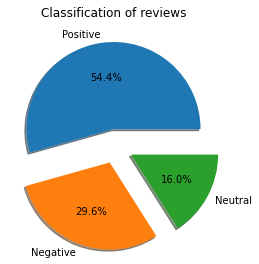

In [77]:
plt.pie(data['sentiment analysis'].value_counts().values, labels = data['sentiment analysis'].value_counts().index, explode = (0.2, 0.2, 0.2), shadow=True, autopct='%1.1f%%')
plt.title('Classification of reviews \n')

plt.show()


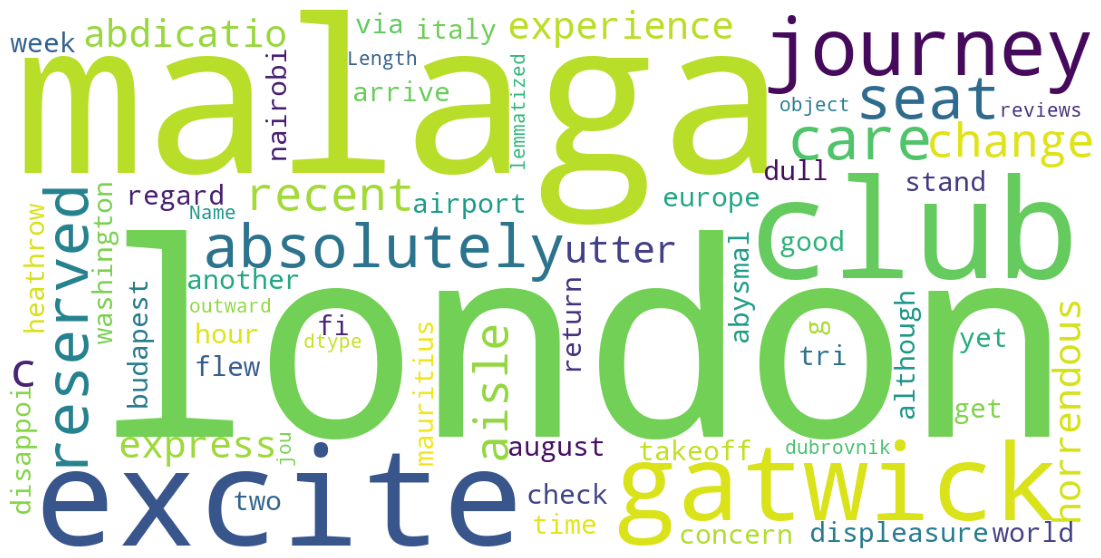

In [66]:
from wordcloud import WordCloud
wordcloud=WordCloud(background_color="white", random_state=1, scale=3, stopwords=stopwords, max_words=1000).generate(str(data['lemmatized reviews']))
# wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, )
plt.axis("off")
plt.show()


In [67]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

ba_mask = np.array(Image.open("ba_logo.png"))
ba_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [68]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_ba_mask = np.ndarray((ba_mask.shape[0],ba_mask.shape[1]), np.int32)

for i in range(len(ba_mask)):
    transformed_ba_mask[i] = list(map(transform_format, ba_mask[i]))

transformed_ba_mask


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

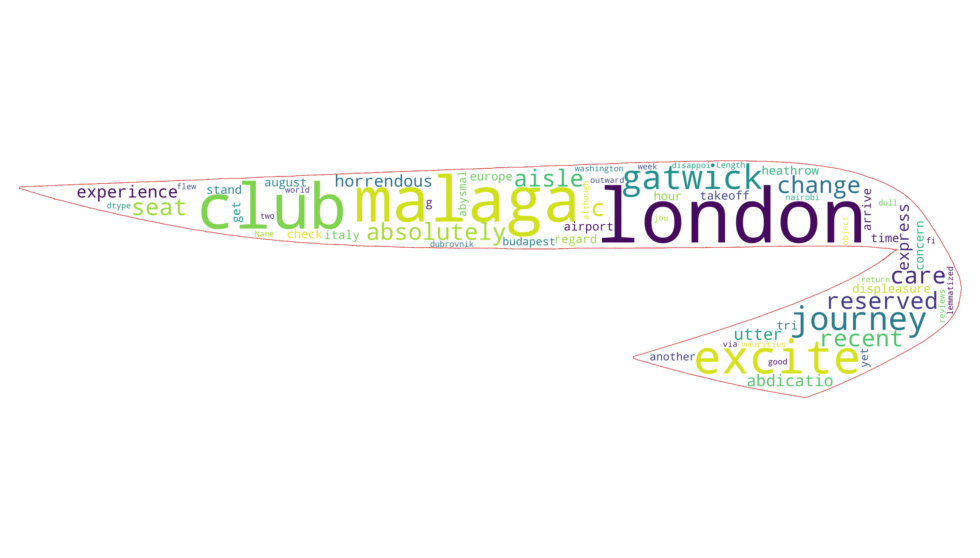

In [69]:
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_ba_mask, scale = 3, 
               stopwords=stopwords, contour_width=10, contour_color='#CC3333')
wc.generate(str(data['lemmatized reviews']))
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()



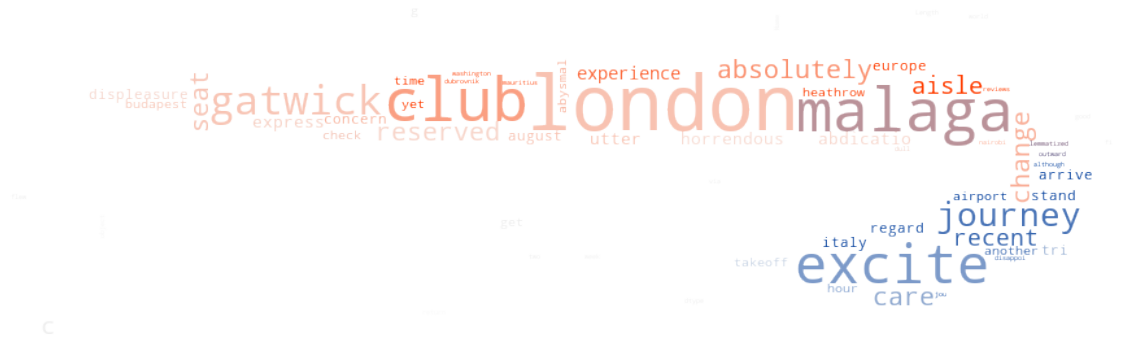

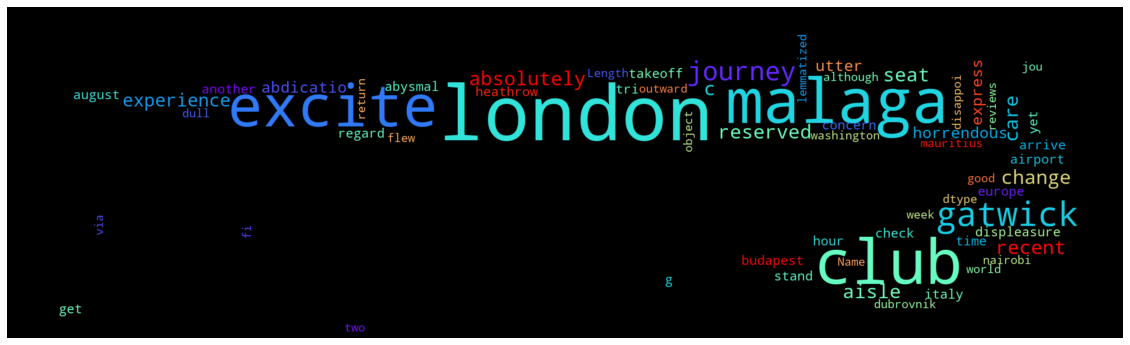

In [81]:
mask = np.array(Image.open("ba.png"))
image_colors = ImageColorGenerator(mask)

wc2 = WordCloud(stopwords=stopwords,background_color="rgba(255, 255, 255, 0)", mode="RGBA", max_words=1000, mask=mask, contour_color=image_colors, random_state = 1).generate(str(data['lemmatized reviews']))

# create coloring from image
plt.figure(figsize=[20,10])
plt.imshow(wc2.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()


wc3 = WordCloud(background_color="black", max_words=2000, mask=mask, scale = 3, 
               stopwords=stopwords, colormap='rainbow', )
wc3.generate(str(data['lemmatized reviews']))
plt.figure(figsize=[20,10])
plt.imshow(wc3, interpolation='bilinear')
plt.axis("off")
plt.show()


In [71]:
data

,Unnamed: 0,dummy,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,...,date difference,month,year,traveller,seat,cleaned reviews,pos tagged reviews,lemmatized reviews,sentiment score,sentiment analysis
0,0,0,Boeing 777,NaN,Economy Class,Los Angeles to London,2023-08-15,1.0,1.0,1.0,...,17,8,2023,NaN,0,british airways absolutely does not care my r...,"[(absolutely, r), (care, v), (reserved, a), (s...",absolutely care reserved seat change aisle c...,-0.9022,Negative
1,1,0,NaN,Couple Leisure,Economy Class,New York JFK to Malaga via London,2023-06-15,1.0,3.0,NaN,...,78,6,2023,2.0,0,my recent experience with british airways was...,"[(recent, a), (experience, n), (horrendous, a)...",recent experience horrendous utter abdicatio...,-0.9272,Negative
2,2,0,NaN,Couple Leisure,Premium Economy,Chicago to Rome via London,2023-07-15,3.0,1.0,1.0,...,47,7,2023,2.0,1,this is to express our displeasure and concer...,"[(express, v), (displeasure, n), (concerns, n)...",express displeasure concern regard italy tri...,-0.4588,Negative
3,3,0,A320,Solo Leisure,Business Class,London to Malaga,2023-08-15,1.0,1.0,1.0,...,15,8,2023,1.0,2,i flew london to malaga on august in club eur...,"[(flew, v), (london, n), (malaga, v), (august,...",fly london malaga august club europe stand a...,-0.7430,Negative
4,4,0,NaN,Solo Leisure,Economy Class,Frankfurt to London Heathrow,2023-08-15,1.0,1.0,NaN,...,15,8,2023,1.0,0,i arrived at the airport about hours before t...,"[(arrived, v), (airport, n), (hours, n), (take...",arrive airport hour takeoff time get check g...,-0.0258,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0,NaN,Solo Leisure,Economy Class,LHR to BUD,2016-10-15,1.0,1.0,1.0,...,-3,10,2016,1.0,0,london heathrow to budapest with british airw...,"[(london, n), (heathrow, n), (budapest, v), (y...",london heathrow budapest yet another abysmal...,-0.8860,Negative
1996,1996,0,A380,Couple Leisure,First Class,IAD to NBO via LHR,2016-09-15,2.0,4.0,4.0,...,26,9,2016,2.0,First Class,washington dulles to nairobi via london was e...,"[(washington, n), (dulles, v), (nairobi, v), (...",washington dull nairobi via london excite fi...,-0.7351,Negative
1997,1997,0,A320,Family Leisure,Economy Class,AGP to LGW,2016-10-15,2.0,4.0,1.0,...,-4,10,2016,3.0,0,flew malaga to gatwick although a better flig...,"[(flew, a), (malaga, n), (gatwick, v), (althou...",flew malaga gatwick although good two week a...,0.6808,Positive
1998,1998,0,Boeing 777,Couple Leisure,Business Class,LGW to MRU,2016-10-15,3.0,4.0,2.0,...,-5,10,2016,2.0,2,we were very excited about our club world jou...,"[(excited, v), (club, n), (world, n), (journey...",excite club world journey mauritius disappoi...,0.7096,Positive


In [72]:
pos_reviews = data[data['sentiment analysis'] == 'Positive']
neg_reviews = data[data['sentiment analysis'] == 'Negative']


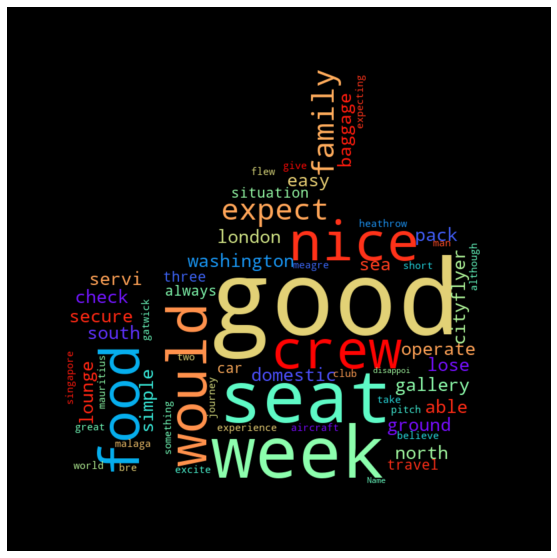

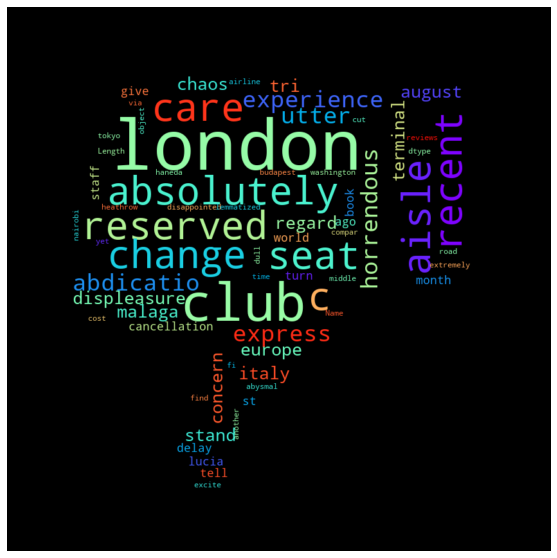

In [73]:
thumbs_up_mask = np.array(Image.open("thumbs up.png"))
thumbs_down_mask = np.array(Image.open("thumbs down.jpg"))

wc_up = WordCloud(background_color="black", max_words=2000, mask=thumbs_up_mask, scale = 3, 
               stopwords=stopwords, colormap='rainbow', )
wc_up.generate(str(pos_reviews['lemmatized reviews']))
plt.figure(figsize=[20,10])
plt.imshow(wc_up, interpolation='bilinear')
plt.axis("off")
plt.show()


wc_down = WordCloud(background_color="black", max_words=2000, mask=thumbs_down_mask, scale = 3, 
               stopwords=stopwords, colormap='rainbow', )
wc_down.generate(str(neg_reviews['lemmatized reviews']))
plt.figure(figsize=[20,10])
plt.imshow(wc_down, interpolation='bilinear')
plt.axis("off")
plt.show()

In [74]:
# data.to_csv("data/BA_reviews - 100 reviews - sentiment analysis.csv")
data.to_csv("data/BA_reviews - 3000 reviews - sentiment analysis.csv")

print('save complete')


save complete
